## CNN With CIFAR - 10

In [34]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [35]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0  Device: cuda


In [36]:
BATCH_SIZE = 32
EPOCHS = 10

In [37]:
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)      

Files already downloaded and verified


In [38]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


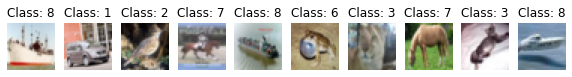

In [39]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

### CNN Modeling

In [46]:
class CNN(nn.Module): # MLP와 마찬가지로, 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Moudel 클래스를 상속받아 Net 클래스를 정의
    def __init__(self):  # CNN 클래스의 인스턴스를 생성했을 때 지니는 성질을 정의해주는 메서드
        super(CNN, self).__init__() # nn.Module 내에 있는 메서드를 상속받아 이용
        self.conv1 = nn.Conv2d( # 2차원의 이미지 데이터를 nn.Conv2D 메서드를 이용해 Convolution 연산을 하는 필터를 정의
            in_channels = 3, # 이미지에 직접 Convolution 연산을 진행하는 필터의 크기는 상관없지만, 채널 수를 이미지의 채널 수와 동일하게 맞춰줘야 함
            out_channels = 8, # Convolution 연산을 진행하는 필터의 개수 설정, 여기서 설정해주는 필터 수만큼 Output의 depth가 정해짐
            kernel_size = 3, # 필터의 크기를 설정해주는 부분, 스칼라 값으로 설정하려면 해당 스칼라 값의 가로 * 세로 크기인 필터를 이용해야 함
            padding = 1 # 이미지의 가장자리에 0을 채워줌으로써, 왼쪽 오른쪽 위 아래에 1층으로 0을 채워주며, 이미지 가장자리와 중앙 부분의 Convolution 연산 횟수를 동일하게 맞춤
        )
        self.conv2 = nn.Conv2d( # 위는 이미지 데이터 자체에 Convolution을 적용하는 필터, 현재는 위의 필터를 통해 생성된 Feature Map과 Convolution 연산을 진행하는 필터 설정
            in_channels = 8, # Feature Map 과 Convolution 연산을 수행하기 위해 Output Depth와 동일하게 맞춤 
            out_channels = 16, # 위와 동일
            kernel_size = 3, # 위와 동일
            padding = 1 # 위와 동일
        )
        self.pool = nn.MaxPool2d( # Convolution을 통해 Feature Map이 생성됐을 때, Feature Map을 전부 이용하지 않고 부분 이용
            kernel_size = 2, # 2 * 2 크기의 필터가 움직이며 가장 큰 Feature Map 값을 추출
            stride = 2 # Feature Map 내에서 2단위로 움직임
        )
        # Convolution을 이용해 추출된 Feature Map은 기존 이미지에서 주변 정보를 수많은 파라미터 값을 이용해 반영된 결과값
        # 다양한 Convolution 연산을 이용해 생성된 Feature Map의 결과는 1차원으로 펼쳐도 이미 주변 정보를 반영한 결과값으로 존재해 기존 MLP 한계를 해결
        self.fc1 = nn.Linear(8 * 8 * 16, 64) # self.conv1과, self.conv2 연산을 이용ㅎ나 결과를 바탕으로 생성된 Feature Map의 크기를 Input으로 받음
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x): # CNN 클래스르 이용해 설계한 CNN 모델의 Forward Propagation을 정의
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [47]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [43]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [44]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [48]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

C:\Users\lucky\AppData\Local\Temp\ipykernel_14740\1990576417.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.273320
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.812640
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.901818
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.689870
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.380787
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.582092
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.271122
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.658547

[EPOCH: 1], 	Test Loss: 1.4508, 	Test Accuracy: 45.83 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.417902
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.556852
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.287705
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.545727
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.504677
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.565107
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.222235
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.251251

[EPOCH: 2], 	Test Loss: 1.3245, 	Test Accuracy: 51.82 % 

## CNN with Data Augmentation

In [50]:
train_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  # 기존은 ToTensor()를 통해 이미지 데이터를 Tensor 형태로 변환시켜주며, 0에서 1 사이의 값으로 정규화
                                  transform = transforms.Compose([ # 불러오는 이미지 데이터 전처리 및 Augmentation을 다양하게 적용할 때 이용하는 메서드
                                    transforms.RandomHorizontalFlip(), # 해당 이미지를 50% 확률로 좌우 반전
                                    transforms.ToTensor(), # 0에서 1사이 값으로 정규화하며, 딥러닝 모델의 Input으로 이용될 수 있도록, Tensor 형태로 변환
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])) # 전환된 이미지에 대해 또 다른 정규화를 진행, red, green, blue 순으로 평균과 표준편차 0.5씩 적용

test_dataset = datasets.CIFAR10(root = "./data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([ # 위와 동일
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [51]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.361197


C:\Users\lucky\AppData\Local\Temp\ipykernel_14740\1990576417.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.978211
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.431454
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.722194
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.399887
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.542360
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.389888
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.576147

[EPOCH: 1], 	Test Loss: 1.3640, 	Test Accuracy: 51.57 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.397588
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.498587
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.425719
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.107161
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.285533
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.186913
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.072751
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.383368

[EPOCH: 2], 	Test Loss: 1.1963, 	Test Accuracy: 57.37 % 

Train Epoch: 3 [0/50000 (0%)]	Train Loss: 0.88551